In [1]:
# this file creates the features used in the trend RNN.
# features will revolve around high frequency (intra-day) mid-freq (daily to weekly), long term ( monthly trends)
# for the intraday factor, should we try for minutely data?
import pandas as pd
import jupyter
import numpy as np
import datetime 
from scipy.stats import norm
import math
from matplotlib import pyplot as plt
# Set up the data that we want to create a DT on.
# import the fx data , econ and value data for EURUSD.
# then create the features (on trend and econ data) standardise and run a DT on the x_train sample.
# what is  target? 1 day ahead or long days ahead? trade on binary data.
csv_file = {"FXData" : r"C:\Users\edgil\Documents\Masters\dissertation\data\CurrencyData.csv",
            "ValueData" : r"",
            "EconData" : r"",
            }
fxdata = pd.read_csv(csv_file["FXData"])
fxdata['Date'] = pd.to_datetime(fxdata['Date'], format= '%d/%m/%Y %H:%M')
# Separate out the EURUSD factor
eurusd = fxdata[["Date", "EURUSD"]]
def get_time(row):
    '''
    Get the time stamp of the day 
    '''
    return row.time()
eurusd['timestamp'] = eurusd['Date'].apply(get_time)
df = eurusd

C:\Users\edgil\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [2]:
# Very important step is to truncate the data so that we do not see the last 1 year of data.
# Q. should we not have a rolling window type of model? or just always aggregate the data from the start?
# how long is testing? we should we the train and test to sizes which make sense to the type of model we use going forward.
eurusd = eurusd.loc[eurusd['Date'] < "2018-01-01 00:00"]
# create a target vector to train on.
# What is the target? binary return? sharpe ratio? This can then help us to position size the trade,
# Build out the feature set on price, this may need to be created using functional process.
eurusd["logret"] = np.log(eurusd["EURUSD"]) - np.log(eurusd["EURUSD"].shift(1))
# Standardising the daily rets and accumulating the standardised returns, or should we sum the % ret and standardise by its own history
# is difference between different accumulated retusn horizons the same as the macd?
# should we standardise by the 1 year forward vol?
# TODO# Functionise the feature code for easy iteration.
short = 5
medium = 15
long = 55
longest = 100
# TODO: Should this be an EMA or simple average? Using EWMA now as we 
# overweight recent history
eurusd['HF_short'] = eurusd["EURUSD"].ewm(short).mean()
eurusd['HF_medium'] = eurusd["EURUSD"].ewm(medium).mean()
eurusd['HF_long'] = eurusd["EURUSD"].ewm(long).mean()
eurusd['HF_longest'] = eurusd["EURUSD"].ewm(longest).mean()
# differences to spot
eurusd['spot_v_HF_short'] = eurusd["EURUSD"] - eurusd['HF_short']
eurusd['spot_v_HF_medium'] = eurusd["EURUSD"] - eurusd['HF_medium']
eurusd['spot_v_HF_long'] = eurusd["EURUSD"] - eurusd['HF_long']
eurusd['spot_v_HF_longest'] = eurusd["EURUSD"] - eurusd['HF_longest'] 

# medium frequency factors, multiplyer allows us to scale up the lookback as needed.
# days to weeks
medium_multiplyer = 24
eurusd['MF_short'] = eurusd["EURUSD"].ewm(short*medium_multiplyer).mean()
eurusd['MF_medium'] = eurusd["EURUSD"].ewm(medium*medium_multiplyer).mean()
eurusd['MF_long'] = eurusd["EURUSD"].ewm(long*medium_multiplyer).mean()
eurusd['MF_longest'] = eurusd["EURUSD"].ewm(longest*medium_multiplyer).mean()
# differences to spot
# to measure relative momentum
eurusd['spot_v_MF_short'] = eurusd["EURUSD"] - eurusd['MF_short']
eurusd['spot_v_MF_medium'] = eurusd["EURUSD"] - eurusd['MF_medium']
eurusd['spot_v_MF_long'] = eurusd["EURUSD"] - eurusd['MF_long']
eurusd['spot_v_MF_longest'] = eurusd["EURUSD"] - eurusd['MF_longest'] 
# long term factors
# weeks to months
long_multiplyer = 120 # each period is now one business week, 24*5
eurusd['LF_short'] = eurusd["EURUSD"].ewm(short*long_multiplyer).mean()
eurusd['LF_medium'] = eurusd["EURUSD"].ewm(medium*long_multiplyer).mean()
eurusd['LF_long'] = eurusd["EURUSD"].ewm(long*long_multiplyer).mean()
eurusd['LF_longest'] = eurusd["EURUSD"].ewm(longest*long_multiplyer).mean()
# differences to spot
# to measure relative momentum
eurusd['spot_v_LF_short'] = eurusd["EURUSD"] - eurusd['LF_short']
eurusd['spot_v_LF_medium'] = eurusd["EURUSD"] - eurusd['LF_medium']
eurusd['spot_v_LF_long'] = eurusd["EURUSD"] - eurusd['LF_long']
eurusd['spot_v_LF_longest'] = eurusd["EURUSD"] - eurusd['LF_longest'] 

# average of both spot distance and each ema distance
# take simple average of the divergences at each time frame
eurusd['spot_v_HF'] = (eurusd['spot_v_HF_short'] + eurusd['spot_v_HF_medium'] + eurusd['spot_v_HF_long'] + eurusd['spot_v_HF_longest'])/4
eurusd['spot_v_MF'] = (eurusd['spot_v_MF_short'] + eurusd['spot_v_MF_medium'] + eurusd['spot_v_MF_long'] + eurusd['spot_v_MF_longest'])/4
eurusd['spot_v_LF'] = (eurusd['spot_v_LF_short'] + eurusd['spot_v_LF_medium'] + eurusd['spot_v_LF_long'] + eurusd['spot_v_LF_longest'])/4 
#differences to each ema
# This can capture the divergences between the EMAs, which allows us to grasp the speed of the move
eurusd['HF_ema_diff'] = (eurusd['HF_short']-eurusd['HF_medium']) + (eurusd['HF_medium']-eurusd['HF_long']) + (eurusd['HF_long']-eurusd['HF_longest'])
eurusd['MF_ema_diff'] = (eurusd['MF_short']-eurusd['MF_medium']) + (eurusd['MF_medium']-eurusd['MF_long']) + (eurusd['MF_long']-eurusd['MF_longest'])
eurusd['LF_ema_diff'] = (eurusd['LF_short']-eurusd['LF_medium']) + (eurusd['LF_medium']-eurusd['LF_long']) + (eurusd['LF_long']-eurusd['LF_longest'])
# Add in hourly feature times. Think this is important as there can be certain patterns that occur into and out
# of these time frames
# London and NY liquid hours
eurusd['LDN'] = 0
eurusd['NY'] = 0
eurusd['Asia'] = 0
# adding in timezone changes
eurusd['LDN'].loc[(eurusd["timestamp"] >= datetime.time(7,0)) & (eurusd["timestamp"] <= datetime.time(12,0))] = 1
eurusd['LDN'].loc[(eurusd["timestamp"] >= datetime.time(13,0)) & (eurusd["timestamp"] <= datetime.time(17,0))] = 0.5
eurusd['NY'].loc[(eurusd["timestamp"] >= datetime.time(13,0)) & (eurusd["timestamp"] <= datetime.time(17,0))] = 0.5
eurusd['NY'].loc[(eurusd["timestamp"] >= datetime.time(18,0)) & (eurusd["timestamp"] <= datetime.time(22,0))] = 1
eurusd['Asia'].loc[(eurusd["timestamp"] >= datetime.time(23,0))] = 1
eurusd['Asia'].loc[(eurusd["timestamp"] <= datetime.time(6,0))] = 1

# Now adding the target vector
targetlkbk = 24
# Using a shift = 2 so that the forward return starts from exactly the next future time step.
eurusd["target"] = eurusd['logret'].iloc[::-1].shift(2).rolling(targetlkbk).sum().values[::-1]
eurusd['target_binary'] = eurusd['target'].apply(np.sign) 
eurusd['CCY'] = eurusd['EURUSD']
eurusd.to_csv(r"C:\Users\edgil\Documents\Masters\dissertation\code64\data_set\ccyData.csv"
                           , index = False)

C:\Users\edgil\AppData\Local\Programs\Python\Python36\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [5]:
# train size should be at least 5 years?
eurusd_train = eurusd.loc[eurusd['Date'] < "2009-01-01 00:00"].reset_index(drop = False)
eurusd_test = eurusd.loc[eurusd['Date'] > "2009-02-01 00:00"].reset_index(drop = False)

# Very important step is to truncate the data so that we do not see the last 1 year of data.
# Q. should we not have a rolling window type of model? or just always aggregate the data from the start?
# Standardise the data using sklearn
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# standardise the data now.
# remove dates
# data_cols = [col for col in eurusd_train.columns if col not in ["Date", "timestamp", "target", "target_binary", "LDN", "NY", "Asia"]]
# this feature set is a small sample that incorporates the features from most of the array
# must functionise this code so that we can compute the train and from there move ahead with the test scaling.
data_cols = ["spot_v_HF", "spot_v_MF", "spot_v_LF", "HF_ema_diff",	"MF_ema_diff","LF_ema_diff"]
data_train = eurusd_train.loc[:, data_cols]
data_test = eurusd_test.loc[:, data_cols]
# this applies te standardisation across the while data set
eurusd_train_normed = pd.DataFrame(scaler.fit_transform(data_train), columns = list(data_train.columns))
# need to add, date , EURUSD also the log rets.
eurusd_train_normed['Date'] = eurusd_train['Date']
eurusd_train_normed['CCY'] = eurusd_train['EURUSD']
eurusd_train_normed['logret'] = eurusd_train['logret']
eurusd_train_normed['LDN'] = eurusd_train['LDN']
eurusd_train_normed['NY'] = eurusd_train['NY']
eurusd_train_normed['Asia'] = eurusd_train['Asia']
eurusd_train_normed['target'] = eurusd_train['target_binary']
eurusd_test_normed = pd.DataFrame(scaler.transform(data_test), columns = list(data_test.columns))
eurusd_test_normed['Date'] = eurusd_test['Date']
eurusd_test_normed['CCY'] = eurusd_test['EURUSD']
eurusd_test_normed['logret'] = eurusd_test['logret']
eurusd_test_normed['LDN'] = eurusd_test['LDN']
eurusd_test_normed['NY'] = eurusd_test['NY']
eurusd_test_normed['Asia'] = eurusd_test['Asia']
eurusd_test_normed['target_raw'] = eurusd_test['target']
eurusd_test_normed['target'] = eurusd_test['target_binary']
#print(eurusd_train_normed.tail(50))
print(eurusd_train_normed.shape)
# send to a a csv so we can pick up for the LSTM
eurusd_train_normed.to_csv(r"C:\Users\edgil\Documents\Masters\dissertation\code64\data_set\eurusd_train_normed.csv", index = False)
eurusd_test_normed.to_csv(r"C:\Users\edgil\Documents\Masters\dissertation\code64\data_set\eurusd_test_normed.csv", index = False)

(56352, 13)


In [24]:
def standardise_data(dataset,cols, window):
    '''
    This function computes the standardised returns.
    :param dataframe:
    :param cols:
    :return:
    '''
    rolling_mean  = dataset[cols].rolling(window).mean()
    rolling_std = dataset[cols].rolling(window).std()

    train_standardised = dataset.subtract(rolling_mean)
    train_standardised = train_standardised.divide(rolling_std)
    # we will only return the data which is outide the initial window standardisation period
    return train_standardised.loc[window:,:]

df = standardise_data(data_train, data_cols, 30000)
print(df.mean())

spot_v_HF     -0.043220
spot_v_MF     -0.173409
spot_v_LF     -0.037299
HF_ema_diff   -0.054672
MF_ema_diff   -0.187242
LF_ema_diff    0.211935
dtype: float64


In [4]:
#### This is where we choose and set up the random forest model for some quick tests.
# Decision trees
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
# need to re do the models here.
X = eurusd_train_normed[['spot_v_HF', 'spot_v_MF',
       'spot_v_LF', 'HF_ema_diff', 'MF_ema_diff', 'LF_ema_diff', 'LDN', 'NY',
       'Asia']]
Y = eurusd_train["target_binary"]
X_test = eurusd_test_normed[['spot_v_HF', 'spot_v_MF',
       'spot_v_LF', 'HF_ema_diff', 'MF_ema_diff', 'LF_ema_diff', 'LDN', 'NY',
       'Asia']]
Y_test = eurusd_test["target_binary"]
# clean the data and nan values
X = X.replace(np.nan, 0)
Y = Y.replace(np.nan, 0)
X_test = X_test.replace(np.nan, 0)
Y_test = Y_test.replace(np.nan, 0)
#RF = RandomForestClassifier(n_estimators = 150, max_features = 5)
#RF.fit(X, Y)
clf = tree.DecisionTreeClassifier(max_leaf_nodes = 10)
clf = clf.fit(X, Y)
# visualise the data
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()
"""export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
                """
tree.export_graphviz(clf, out_file=dot_data, class_names=['Sell',"Hold","Buy"], feature_names= ['spot_v_HF', 'spot_v_MF',
       'spot_v_LF', 'HF_ema_diff', 'MF_ema_diff', 'LF_ema_diff', 'LDN', 'NY',
       'Asia'], filled=True, rounded=True, special_characters = True) 
graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
graph.write_pdf("trend.pdf")

True

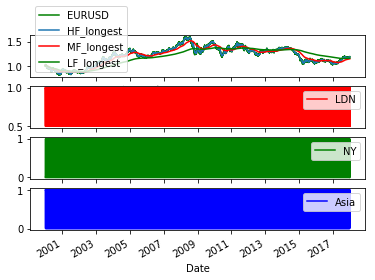

In [74]:
# creating some interesting plots
fig , ax = plt.subplots(4,1)
eurusd.plot(x = "Date", y = "EURUSD" , ax = ax[0], c = "g")
eurusd.plot(x = "Date", y = "HF_longest" , ax = ax[0])
eurusd.plot(x = "Date", y = "MF_longest", ax = ax[0], c = "r")
eurusd.plot(x = "Date", y = "LF_longest", ax = ax[0], c = "g")
# plot on the second axis.
eurusd.plot(x = "Date", y = 'LDN', ax = ax[1], c = "r")
eurusd.plot(x = "Date", y = 'NY', ax = ax[2], c = "g")
eurusd.plot(x = "Date", y = 'Asia', ax = ax[3], c = "b")



In [6]:
#eurusd['timestamp'].loc[(eurusd["timestamp"] >= datetime.time(8,0) & eurusd["timestamp"] <= datetime.time(17,0) )]
#eurusd["timestamp"].loc[1] > datetime.time(8,0)
#eurusd['LDN'] = eurusd['timestamp'].loc[(eurusd["timestamp"] >= datetime.time(8,0)) & (eurusd["timestamp"] <= datetime.time(12,0))] = 1
#eurusd['LDN'] = 0
#eurusd['NY'] = 0
eurusd['Asia'] = 0
# adding in timezone changes
eurusd['LDN'] = eurusd['LDN'].loc[(eurusd["timestamp"] >= datetime.time(7,0)) & (eurusd["timestamp"] <= datetime.time(12,0))] = 1
eurusd['LDN'].loc[(eurusd["timestamp"] >= datetime.time(13,0)) & (eurusd["timestamp"] <= datetime.time(17,0))] = 0.5
eurusd['NY'].loc[(eurusd["timestamp"] >= datetime.time(13,0)) & (eurusd["timestamp"] <= datetime.time(17,0))] = 0.5
eurusd['NY'].loc[(eurusd["timestamp"] >= datetime.time(18,0)) & (eurusd["timestamp"] <= datetime.time(22,0))] = 1
eurusd['Asia'].loc[(eurusd["timestamp"] >= datetime.time(23,0))] = 1
eurusd['Asia'].loc[(eurusd["timestamp"] <= datetime.time(6,0))] = 1

C:\Users\edgil\AppData\Local\Programs\Python\Python36\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [7]:
#eurusd['LDN'] = 0
#eurusd['LDN'].loc[(eurusd["timestamp"] >= datetime.time(7,0)) & (eurusd["timestamp"] <= datetime.time(12,0))] = 1
#print(eurusd[["Date", "Asia", 'LDN', "NY"]].head(50))
Y_predict = clf.predict_log_proba(X_test)

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
print(accuracy_score(Y_test, Y_predict))

print(pd.DataFrame(
    confusion_matrix(Y_test, Y_predict),
    columns=['Predicted Buy', 'Predicted Hold','Predicted Sell'],
    index=['True Buy', "True Hold", 'True Sell']
))

ValueError: Classification metrics can't handle a mix of multiclass and continuous-multioutput targets

In [8]:
Y_predict = clf.predict_proba(X_test)
#plt.hist(Y_predict)
signal_thold = 0.52
eurusd_test['sell'] = pd.Series(Y_predict[:,0])
eurusd_test['hold'] = pd.Series(Y_predict[:,1])
eurusd_test['buy'] = pd.Series(Y_predict[:,2])
eurusd_test['signal'] = 0
eurusd_test['signal'].loc[eurusd_test['sell'] > signal_thold ] = -1
eurusd_test['signal'].loc[eurusd_test['buy'] > signal_thold ] = 1
eurusd_test['return'] = eurusd_test['signal']*eurusd_test['logret'].shift(2)
eurusd_test['cumul_return'] = eurusd_test['return'].cumsum()


C:\Users\edgil\AppData\Local\Programs\Python\Python36\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [3]:
from create_model_features import *
CCY_COL = "EURUSD"
short, medium, long, longest = 21, 55, 100 ,200
medium_multiplier  = 24 # daily
long_multplier = 120 # weekly
df = trends_features(df,CCY_COL, short, medium, long, longest, medium_multiplier,long_multplier)
df.to_csv(r"C:\Users\edgil\Documents\Masters\dissertation\code64\data_set\CcyDataLONGER.csv")

C:\Users\edgil\Documents\Masters\dissertation\code\create_model_features.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data["logret"] = np.log(data[CCY_COL]) - np.log(data[CCY_COL].shift(1))
C:\Users\edgil\Documents\Masters\dissertation\code\create_model_features.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data['HF_short'] = data[CCY_COL].ewm(short).mean()
C:\Users\edgil\Documents\Masters\dissertation\code\create_model_features.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

C:\Users\edgil\Documents\Masters\dissertation\code\create_model_features.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data['HF_longest'] = data[CCY_COL].ewm(longest).mean()


In [6]:
df = add_timezones(df)
print(df)

C:\Users\edgil\AppData\Local\Programs\Python\Python36\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


                      Date   EURUSD timestamp    logret  HF_short  HF_medium  \
0      2000-01-03 00:00:00  1.01285  00:00:00       NaN  1.012850   1.012850   
1      2000-01-03 01:00:00  1.01285  01:00:00  0.000000  1.012850   1.012850   
2      2000-01-03 02:00:00  1.01750  02:00:00  0.004580  1.014690   1.014501   
3      2000-01-03 03:00:00  1.01750  03:00:00  0.000000  1.015594   1.015325   
4      2000-01-03 04:00:00  1.01675  04:00:00 -0.000737  1.015916   1.015648   
5      2000-01-03 05:00:00  1.01675  05:00:00  0.000000  1.016125   1.015862   
6      2000-01-03 06:00:00  1.01690  06:00:00  0.000148  1.016304   1.016041   
7      2000-01-03 07:00:00  1.01690  07:00:00  0.000000  1.016434   1.016174   
8      2000-01-03 08:00:00  1.01375  08:00:00 -0.003102  1.015879   1.015830   
9      2000-01-03 09:00:00  1.01375  09:00:00  0.000000  1.015456   1.015557   
10     2000-01-03 10:00:00  1.01165  10:00:00 -0.002074  1.014723   1.015076   
11     2000-01-03 11:00:00  1.01165  11: